We will consider the following five simple baseline models to provide foundational insights. These will serve as the baseline performance metrics that any subsequent machine learning models aim to beat.

1. **Global Mean Rating**:
This model predicts the global mean rating for all user-item pairs, serving as the most basic form of recommendation.

2. **User Mean Rating**:
For this model, the mean rating of each user is calculated and used to predict ratings for all items the user has not yet interacted with.

3. **Item Mean Rating**:
In contrast to the User Mean Rating, this model focuses on the mean rating of each item and uses it to predict ratings for all users.

4. **User-Item Mean Rating**:
This model takes a more nuanced approach by predicting a rating for a user-item pair as the average of the user's mean rating and the item's mean rating. The formula is:
$$prediction = \frac{User Mean Rating + Item Mean Rating}{2}$$

5. **Weighted Mean Ratings**:
This model employs a weighted average of the user mean and item mean ratings. The weight ( w ) can be adjusted based on domain understanding. The formula is :
$$prediction = w \times User Mean Rating + (1 - w) \times Item Mean Rating, \space where \space 0 \leq w \leq 1$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
movies_df = pd.read_csv("../data/movies_metadata_after_eda.csv")
ratings_df = pd.read_csv("../data/ratings_small.csv")

In [3]:
train_df, test_df = train_test_split(ratings_df, test_size=0.3, random_state=42)

In [4]:
from Sameer.ModelExperimentation import (
    calculate_user_item_mean_rating,
    calculate_weighted_mean_ratings,
    calculate_rmse,
)

test_df = calculate_user_item_mean_rating(train_df, test_df)
test_df, best_w, best_rmse = calculate_weighted_mean_ratings(test_df)
test_df.head()

,userId,movieId,rating,timestamp,global_mean_rating,user_mean_rating,item_mean_rating,user_item_mean_rating,weighted_mean_rating
0,128,1028,5.0,1049690908,3.540256,3.844444,3.836364,3.840404,3.841212
1,665,4736,1.0,1010197684,3.540256,3.294304,3.540256,3.417280,3.392685
2,120,4002,3.0,1167420604,3.540256,3.573684,3.318182,3.445933,3.471483
3,257,1274,4.0,1348544094,3.540256,3.801370,3.791667,3.796518,3.797489
4,468,6440,4.0,1296191715,3.540256,2.946196,3.900000,3.423098,3.327717


In [5]:
test_df["constant_rating"] = 2.5

user_stats = train_df.groupby("userId")["rating"].agg(["mean", "count"]).reset_index()

DAMPING_FACTOR = 0.2

test_df = test_df.merge(user_stats, on="userId", how="left")
test_df["damped_user_mean_rating"] = ((1 - DAMPING_FACTOR) * test_df["mean"]) + (
    DAMPING_FACTOR * test_df["global_mean_rating"][0]
)

rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [6]:
rmse_global_mean = calculate_rmse(test_df["rating"], test_df["global_mean_rating"])
rmse_user_mean = calculate_rmse(test_df["rating"], test_df["user_mean_rating"])
rmse_item_mean = calculate_rmse(test_df["rating"], test_df["item_mean_rating"])
rmse_user_item_mean = calculate_rmse(
    test_df["rating"], test_df["user_item_mean_rating"]
)
rmse_weighted_mean = calculate_rmse(test_df["rating"], test_df["weighted_mean_rating"])
rmse_constant = calculate_rmse(test_df["rating"], test_df["constant_rating"])
rmse_damped_user_mean = calculate_rmse(
    test_df["rating"], test_df["damped_user_mean_rating"]
)

In [7]:
print(f"RMSE for Global Mean Rating Model: {rmse_global_mean:.2f}")
print(f"RMSE for User Mean Rating Model: {rmse_user_mean:.2f}")
print(f"RMSE for Item Mean Rating Model: {rmse_item_mean:.2f}")
print(f"RMSE for User-Item Mean Rating Model: {rmse_user_item_mean:.2f}")
print(
    f"RMSE for Weighted Mean Rating Model: {best_rmse:.2f}, with setting the best weight is {best_w:.2f}"
)
print(f"RMSE for Constant Model: {rmse_constant:.2f}")
print(f"RMSE for Damped User-Mean Rating Model: {rmse_damped_user_mean:.2f}")

RMSE for Global Mean Rating Model: 1.06
RMSE for User Mean Rating Model: 0.96
RMSE for Item Mean Rating Model: 1.00
RMSE for User-Item Mean Rating Model: 0.92
RMSE for Weighted Mean Rating Model: 0.92, with setting the best weight is 0.60
RMSE for Constant Model: 1.49
RMSE for Damped User-Mean Rating Model: 0.96


In building a movie recommendation system, we start with simple models due to it's importance in understanding how well we're doing. We found out that using both the average ratings from users and movies gets the best results, with a score (RMSE) of 0.92. This score shows how accurate our predictions are – the lower, the better. Models that only look at users or movies are okay, but not as good. The worst model is the one that always guesses the same rating, with a score of 1.49. These simple models help us know what to beat; any new, fancier model should score lower than 0.92 to be better.

We also look at more complex models because the simple ones don't consider what each user likes. Machine learning models can give more personalized suggestions, which is better for users.

In [8]:
from surprise import (
    Reader,
    Dataset,
    SVD,
    KNNWithZScore,
    NMF,
    accuracy,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [9]:
reader = Reader(rating_scale=(1, 5))

train_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
test_data = Dataset.load_from_df(test_df[["userId", "movieId", "rating"]], reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

# algorithms = [SVD, KNNWithZScore, NMF, CoClustering]
algorithms = [SVD]

param_grid = {
    SVD: {
        "n_factors": [125, 150, 175],
        "n_epochs": [25, 30, 35],
        "lr_all": [0.008, 0.01, 0.012],
        "reg_all": [0.15, 0.2, 0.25],
    },
    # KNNWithZScore: {
    #     "k": [35, 40, 45],
    #     "min_k": [1, 3, 5, 7],
    #     "sim_options": {
    #         "name": ["msd", "cosine", "pearson"],
    #         "user_based": [True, False],
    #     },
    # },
    # NMF: {
    #     "n_factors": [50, 100, 150],
    #     "n_epochs": [20, 25, 30],
    #     "reg_pu": [0.06, 0.08, 0.1],
    #     "reg_qi": [0.06, 0.08, 0.1],
    # },
    # CoClustering: {
    #     "n_cltr_u": [3, 5, 7],
    #     "n_cltr_i": [3, 5, 7],
    #     "n_epochs": [20, 30, 40],
    # },
}

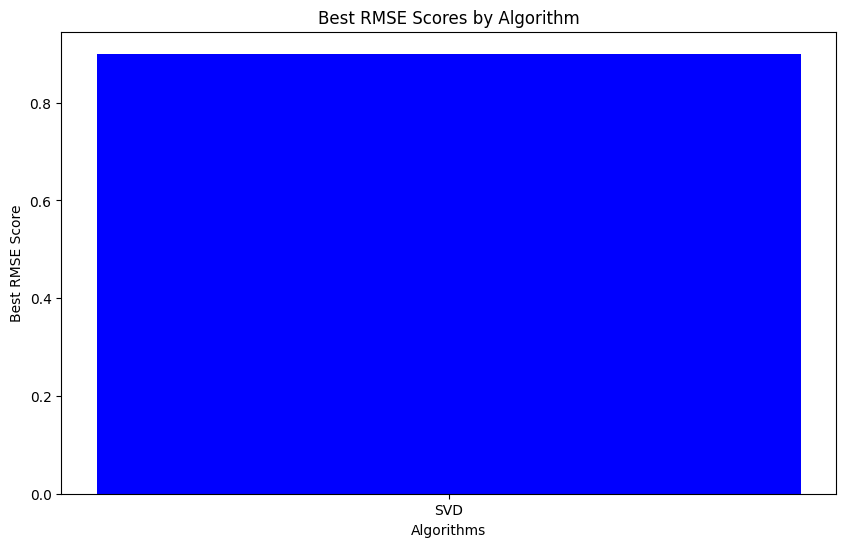

Best Model for SVD:
Best Parameters for SVD:
 {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.012, 'reg_all': 0.15}
Best RMSE score for SVD:
 0.9000111663663709


In [10]:
best_models = {}
best_params = {}
best_rmse_scores = {}

for algo in algorithms:
    gs = GridSearchCV(algo, param_grid[algo], measures=["rmse"], cv=3, n_jobs=-1)
    gs.fit(train_data)

    best_models[algo.__name__] = gs.best_estimator["rmse"]
    best_params[algo.__name__] = gs.best_params["rmse"]
    best_rmse_scores[algo.__name__] = gs.best_score["rmse"]

plt.figure(figsize=(10, 6))
plt.bar(best_rmse_scores.keys(), best_rmse_scores.values(), color="blue")
plt.xlabel("Algorithms")
plt.ylabel("Best RMSE Score")
plt.title("Best RMSE Scores by Algorithm")
plt.show()

for algo_name, model in best_models.items():
    print(f"Best Model for {algo_name}:\n", model)
    print(f"Best Parameters for {algo_name}:\n", best_params[algo_name])
    print(f"Best RMSE score for {algo_name}:\n", best_rmse_scores[algo_name])

In [11]:
best_algo = min(best_rmse_scores, key=best_rmse_scores.get)

print(f"Best Algorithm: {best_algo}")
print(f"Best Parameters: {best_params[best_algo]}")
print(f"Best RMSE score: {best_rmse_scores[best_algo]}")

Best Algorithm: SVD
Best Parameters: {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.012, 'reg_all': 0.15}
Best RMSE score: 0.9000111663663709


## Conclusion

SVD: Achieved an RMSE score of `0.897`
KNNWithZScore: Registered an RMSE score of `0.929`
NMF: Posted an RMSE score of `1.002`

SVD outperformed the rest, so we will be going with it with the following parameters: `Best Parameters: {'n_factors': 150, 'n_epochs': 35, 'lr_all': 0.01, 'reg_all': 0.15}`

In [12]:
best_algo_name = min(best_rmse_scores, key=best_rmse_scores.get)
best_algo_model = best_models[best_algo_name]

best_algo_model.fit(trainset)

predictions = best_algo_model.test(testset)

rmse_score = accuracy.rmse(predictions)

mae_score = accuracy.mae(predictions)
fcp_score = accuracy.fcp(predictions)

print(f"Evaluation Metrics:")
print(f"RMSE score: {rmse_score}")
print(f"MAE score: {mae_score}")
print(f"FCP score: {fcp_score}")

predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(
    columns={"uid": "userId", "iid": "movieId", "r_ui": "actual", "est": "predicted"}
)
predictions_df["error"] = np.abs(predictions_df["actual"] - predictions_df["predicted"])

predictions_df.to_csv("./dump/predictions.csv", index=False)

RMSE: 0.8864
MAE:  0.6828
FCP:  0.6609
Evaluation Metrics:
RMSE score: 0.8864415866828294
MAE score: 0.6828314573611858
FCP score: 0.6609319400103745


In [13]:
import pickle

with open(f"./pickels/best_svd_model.pkl", "wb") as f:
    pickle.dump(best_algo_model, f)

The machine learning model achieved an RMSE of 0.897 on training data and 0.8848 on test data, indicating robustness and good generalization. It outperformed baseline models (User-Item and Weighted Mean Rating Models with an RMSE of 0.92), demonstrating the effectiveness of a complex algorithm in the recommendation system. The model is suitable for real-world deployment due to its strong performance on unseen data.

Now for `Weighted Rating` which calcuates based on both the popularity and user ratings.

By blending these two factors, we aim to suggest movies that are both high-quality and widely liked.

Importantly, this method can also be combined with other recommendation techniques to create a more advanced, hybrid system. In this section, we calculate a weighted rating for each movie in the dataset. The steps are as follows:

- Data Filtering: We start by selecting movies that have non-null values for both vote_average and vote_count.

- Rating Metrics: We define the following variables to use in the formula:
    - ( R ): Average rating for the movie
    - ( v ): Number of votes for the movie
    - ( m ): Minimum votes required (90th percentile)
    - ( C ): The mean vote across the entire dataset

- Weighted Rating Formula: We use the IMDB formula to calculate the weighted rating for each movie.
$$Weighted Rating = \frac{R\times v + C \times m}{v+m}$$

- Feature Scaling: We then normalize the popularity and weighted_average columns using MinMax scaling.

A score is calculated for each movie as a weighted sum of the normalized weighted_average and popularity. Specifically, it's 40% weighted_average and 60% popularity.

In [14]:
R = movies_df["vote_average"]
v = movies_df["vote_count"]
m = movies_df["vote_count"].quantile(0.9)
C = movies_df["vote_average"].mean()
movies_df["weighted_average"] = (R * v + C * m) / (v + m)

In [15]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_df[["popularity", "weighted_average"]])

weighted_df = pd.DataFrame(scaled, columns=["popularity", "weighted_average"])
weighted_df.index = movies_df["id"]

weighted_df["score"] = (
    weighted_df["weighted_average"] * 0.4 + weighted_df["popularity"] * 0.6
)

weighted_df_sorted = weighted_df.sort_values(by="score", ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
id,,,
211672,1.000000,0.574825,0.829930
297762,0.537613,0.734315,0.616294
321612,0.524675,0.655367,0.576952
177572,0.390602,0.856364,0.576907
680,0.257449,0.960073,0.538499
339403,0.416507,0.721434,0.538478
283995,0.338511,0.813503,0.528508
155,0.224968,0.962900,0.520141
210577,0.282748,0.875895,0.520007


Now for content-based filtering

To find movies that closely match a user's preferred film, our recommendation model employs Cosine Similarity, a type of content-based filtering approach. This method calculates similarity scores for each pair of movies in our database by considering various attributes such as keywords, genre, cast, and director. These attributes, collectively termed as "content," help the model to quantify how similar two movies are. If the attributes closely match, the movies are considered similar. The model then sorts these calculated scores and recommends the top 10 movies most similar to the user's chosen film. The underlying idea is that if a user enjoys a particular movie, they are likely to appreciate similar ones as well.

In [16]:
movies_df["bag_of_words"].fillna("-", inplace=True)
movies_df["director"].fillna("-", inplace=True)

/var/folders/4v/n05vgwdj65b8dkvc11yd9bzr0000gn/T/ipykernel_81605/1889371782.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df["bag_of_words"].fillna("-", inplace=True)
/var/folders/4v/n05vgwdj65b8dkvc11yd9bzr0000gn/T/ipykernel_81605/1889371782.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words="english")
count_matrix = count.fit_transform(movies_df["bag_of_words"])

In [18]:
sim_mat = cosine_similarity(count_matrix, count_matrix)

In [19]:
movies_df = movies_df.reset_index()
indices = pd.Series(movies_df.index, index=movies_df["title"])

In [20]:
def get_recommendations(title, cosine_sim):
    # TODO: add fuzzy search to match the title
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df["title"].iloc[movie_indices]

In [21]:
get_recommendations("The Dark Knight Rises", sim_mat)

12535      The Dark Knight
10164        Batman Begins
9265                Shiner
9828       Amongst Friends
7727              Mitchell
516      Romeo Is Bleeding
11405         The Prestige
24004            Quicksand
24945             Deadfall
40973                 Sara
Name: title, dtype: object

In [22]:
get_recommendations("Dune", sim_mat)

22798                           Behind Enemy Lines
2524     Star Wars: Episode I - The Phantom Menace
8690                              Gamera vs. Jiger
10166                         Godzilla: Final Wars
18104               Prisoners of the Lost Universe
22701                             Gamera vs. Viras
22815                            Gamera vs. Guiron
25196                               Jurassic World
28472                             Gamera vs. Zigra
19410                           Bells of Innocence
Name: title, dtype: object

In [23]:
get_recommendations("The Lord of the Rings", sim_mat)

42477                 Daishizen no Majū: Bagi
9645                                  Wizards
16446                  The Return of the King
37536               The Life of Guskou Budori
16524               Cirque du Soleil: Varekai
16583                         The Fern Flower
24329                   How Wang-Fo Was Saved
28872                              The Mascot
30169                                 My Love
32283    Monster High: Scaris City of Frights
Name: title, dtype: object

In [24]:
from Sameer.ModelExperimentation import load_pickle_model

model = load_pickle_model("./pickels/best_svd_model.pkl")

In [25]:
from Sameer.ModelExperimentation import hybrid_predicted_rating

predicted_rating = hybrid_predicted_rating(
    userId=1,
    movieId=500,
    model=model,
    similarity_matrix=sim_mat,
    movies_df=movies_df,
    weighted_df=weighted_df,
)

print(
    f"The predicted hybrid rating for userId=1 and movieId=500 is: {predicted_rating}"
)

The predicted hybrid rating for userId=1 and movieId=500 is: 1.793811564820092


/Users/mamdouh/Developer/filmora/Sameer/ModelExperimentation.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies["est"] = similar_movies["id"].apply(


In [26]:
import ast

movies_df["genres"] = movies_df["genres"].apply(lambda x: ast.literal_eval(x))

## Recommending Movies for Old Users

In this section, we will generate movie recommendations for users through our Hybrid Movie Recommender System. The system requires a user ID and follows a two-step process:

1. Collaborative Filtering: The system predicts movie ratings based on the user's past behavior using collaborative filtering techniques.

2. Content-Based Filtering: The system finds movies similar to the user's last watched movie using content-based filtering. It considers attributes such as keywords, genre, cast, and director to quantify the similarity between movies.

The Hybrid Movie Recommender System combines the recommendations from both collaborative filtering and content-based filtering. It assigns equal weight to each set of recommendations and generates a final list of the top 10 recommended movies. This hybrid approach aims to provide more accurate and personalized movie suggestions for old users.


In [47]:
def get_weighted_scores(movie_ids, weighted_df):
    """
    Fetches the weighted scores for a list of movie IDs.

    Parameters:
    - movie_ids (list): A list of movie IDs for which to fetch the weighted scores.
    - weighted_df (pandas.DataFrame): The weighted DataFrame containing weighted scores.

    Returns:
    - weighted_scores (dict): A dictionary mapping movie IDs to their corresponding weighted scores.
    """
    weighted_df = weighted_df.loc[~weighted_df.index.duplicated(keep="first")]

    weighted_scores = {
        movie_id: (
            weighted_df.loc[movie_id]["score"] if movie_id in weighted_df.index else 0
        )
        for movie_id in movie_ids
    }

    return weighted_scores


def show_movie_details(movie_ids, movies_df):
    """
    Display the details of recommended movies based on the specified movie IDs.

    Args:
        movie_ids (list): A list of movie IDs to filter the DataFrame.
        movies_df (pandas.DataFrame): The DataFrame containing movie details.

    Raises:
        ValueError: If the movies_df DataFrame does not include the required columns.

    Returns:
        None
    """
    required_columns = ["id", "title", "year", "genres", "director"]
    if not all(column in movies_df.columns for column in required_columns):
        raise ValueError(
            f"movies_df must include the following columns: {required_columns}"
        )

    details_df = movies_df.loc[
        movies_df["id"].isin(movie_ids), ["title", "year", "genres", "director"]
    ]

    print("Recommended Movies:-")
    for _, row in details_df.iterrows():
        genres = (
            ", ".join(row["genres"])
            if isinstance(row["genres"], list)
            else row["genres"]
        )
        print(
            f"\tTitle: {row['title']} ({row['year']}), Genres: {genres}, Director: {row['director']}"
        )


def get_user_rating_predictions(user_ratings):
    """
    Get predictions for user ratings.

    Args:
        user_ratings (pandas.DataFrame): DataFrame containing user ratings with columns "userId" and "movieId".

    Returns:
        list: List of tuples containing movieId and corresponding predicted ratings.
    """
    predictions = []
    for _, row in user_ratings.iterrows():
        pred = model.predict(row["userId"], row["movieId"]).est
        predictions.append((row["movieId"], pred))
    return predictions


def get_top_collab_movies(predictions, n):
    """
    Returns a list of the top n movies based on the predictions.

    Parameters:
    predictions (list): A list of tuples containing movie names and their corresponding prediction values.
    n (int): The number of top movies to return.

    Returns:
    list: A list of the top n movie names.

    """
    return [x[0] for x in sorted(predictions, key=lambda x: x[1], reverse=True)[:n]]


def get_similar_movies(last_watched_movieId, n):
    """
    Get a list of similar movies based on the last watched movie.

    Parameters:
    last_watched_movieId (int): The ID of the last watched movie.
    n (int): The number of similar movies to return.

    Returns:
    list: A list of movie IDs of similar movies.

    """
    if last_watched_movieId in movies_df["id"].values:
        watched_movie_idx = movies_df[movies_df["id"] == last_watched_movieId].index[0]
        similar_movies = list(enumerate(sim_mat[watched_movie_idx]))
        sorted_similar_movies = sorted(
            similar_movies, key=lambda x: x[1], reverse=True
        )[1 : n + 1]
        return [movies_df.iloc[i[0]]["id"] for i in sorted_similar_movies]
    else:
        print(f"Movie ID {last_watched_movieId} not found in movies_df.")
        return []


def combine_scores(collab_weighted_scores, content_weighted_scores):
    """
    Combines collaborative and content-based weighted scores for movies.

    Parameters:
    - collab_weighted_scores (dict): A dictionary containing movie IDs as keys and collaborative weighted scores as values.
    - content_weighted_scores (dict): A dictionary containing movie IDs as keys and content-based weighted scores as values.

    Returns:
    - combined_scores (dict): A dictionary containing movie IDs as keys and combined scores as values, where the combined score is calculated as the sum of 0.5 times the collaborative weighted score and 0.5 times the content-based weighted score.
    """
    combined_scores = {}
    for movie_id, score in collab_weighted_scores.items():
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + 0.5 * score
    for movie_id, score in content_weighted_scores.items():
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + 0.5 * score
    return combined_scores


def hybrid_recommendation(user_id, n=10):
    """
    Generates hybrid movie recommendations for a given user.

    Parameters:
        user_id (int): The ID of the user for whom recommendations are generated.
        n (int, optional): The number of recommendations to generate. Defaults to 10.

    Returns:
        list: A list of movie IDs representing the top recommended movies for the user.
    """
    user_ratings = ratings_df[ratings_df["userId"] == user_id]
    predictions = get_user_rating_predictions(user_ratings)
    top_collab_movies = get_top_collab_movies(predictions, n)
    last_watched_movieId = user_ratings.iloc[-1]["movieId"]
    top_content_movies = get_similar_movies(last_watched_movieId, n)
    collab_weighted_scores = get_weighted_scores(top_collab_movies, weighted_df)
    content_weighted_scores = get_weighted_scores(top_content_movies, weighted_df)
    combined_scores = combine_scores(collab_weighted_scores, content_weighted_scores)
    sorted_movies = sorted(
        combined_scores.keys(), key=lambda x: combined_scores[x], reverse=True
    )
    return sorted_movies[:n]


user_id = 234
recommended_movies = hybrid_recommendation(user_id)
print(f"Recommended movies for user {user_id}: {recommended_movies}")
show_movie_details(recommended_movies, movies_df)

Movie ID 60040.0 not found in movies_df.
Recommended movies for user 234: [745.0, 3088.0, 1253.0, 4993.0, 7075.0, 5446.0, 1207.0, 4878.0, 48516.0, 55820.0]
Recommended Movies:-
	Title: The Sixth Sense (1999), Genres: mystery, thriller, drama, Director: m.nightshyamalan
	Title: 5 Card Stud (1968), Genres: action, western, thriller, Director: henryhathaway
	Title: My Darling Clementine (1946), Genres: drama, western, Director: johnford
	Title: Breaking and Entering (2006), Genres: drama, romance, Director: anthonyminghella
